In [11]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [12]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

In [13]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM =800
    IMAGE_MAX_DIM =1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4 * 6, 8 * 6, 16 * 6,32 * 6, 64 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH =100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50


config = ShapesConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [14]:
class DrugDataset(utils.Dataset):

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_json_get_labels_form(self,image_id):
        info = self.image_info[image_id]
        with open(info['json_path']) as f:
            data = json.load(f)
        data = data["objects"]
        label_list = []
        labels_form = []
        # polygons = []
        # polygons_list = []
        for i in range(len(data)):
            label_list.append(data[i]['label'])
        for i in range(len(label_list)):
            if label_list[i]==33:
                labels_form.append(33000+i)
        num_obj=len(labels_form)

        # polygons.append(data[i]['polygons'][0])
        # for i in range(len(label_list)):
        #     if label_list[i] == 33 or label_list[i] == 161:
        #         labels_form.append('car')
        #         polygons_list.append(polygons[i])
        #     elif label_list[i] == 34 or label_list[i] == 162:
        #         labels_form.append('motorbicycle')
        #         polygons_list.append(polygons[i])
        #     elif label_list[i] == 35 or label_list[i] == 163:
        #         labels_form.append('bicycle')
        #         polygons_list.append(polygons[i])
        #     elif label_list[i] == 36 or label_list[i] == 164:
        #         labels_form.append('person')
        #         polygons_list.append(polygons[i])
        #     elif label_list[i] == 37 or label_list[i] == 165:
        #         labels_form.append('rider')
        #         polygons_list.append(polygons[i])
        #     elif label_list[i] == 38 or label_list[i] == 166:
        #         labels_form.append('truck')
        #         polygons_list.append(polygons[i])
        #     elif label_list[i] == 39 or label_list[i] == 167:
        #         labels_form.append('bus')
        #         polygons_list.append(polygons[i])
        #     elif label_list[i] == 40 or label_list[i] == 168:
        #         labels_form.append('tricycle')
        #         polygons_list.append(polygons[i])
        # num_obj = len(labels_form)

        return labels_form,num_obj
    # 重新写draw_mask

    def load_shapes(self, count, width,height,img_floder, mask_floder, imglist, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes

        self.add_class("shapes", 1, "car")


        for i in range(count):
            # 获取图片宽和高

            filestr = imglist[i].split(".")[0]
            mask_path = mask_floder + "/" + filestr + "_instanceIds.png"
            json_path = mask_floder + "/" + filestr + ".json"
            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                            width=width, height=height, mask_path=mask_path,json_path=json_path)


    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        # count = 1  # number of object
        img = Image.open(info['mask_path'])
        car_list,num_obj=self.from_json_get_labels_form(image_id)

        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    at_pixel = img.getpixel((i, j))
                    if at_pixel ==car_list[index]:
                        mask[j,i,index]=1
        class_ids = np.ones((num_obj))

        return mask, class_ids.astype(np.int32)

In [15]:
#基础设置
dataset_root_path="/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/"
img_floder = dataset_root_path + "pic"
mask_floder = dataset_root_path + "cv2_mask"
#yaml_floder = dataset_root_path
imglist = os.listdir(img_floder)
count = len(imglist)

#train与val数据集准备
dataset_train = DrugDataset()
dataset_train.load_shapes(count,3384,2710,img_floder, mask_floder, imglist,dataset_root_path)
dataset_train.prepare()

#print("dataset_train-->",dataset_train._image_ids)

dataset_val = DrugDataset()
dataset_val.load_shapes(15,3384,2710,img_floder, mask_floder, imglist,dataset_root_path)
dataset_val.prepare()

In [17]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

FileNotFoundError: [Errno 2] Could not find weight files in /home/mt/桌面/Mask_RCNN-master/logs/shapes20180929T1002

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20,
            layers="all")

In [28]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/mt/桌面/Mask_RCNN-master/logs/shapes20180929T1014/mask_rcnn_shapes_0001.h5
Re-starting from epoch 1


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 3384.00000  float64
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:  205.00000  max:  873.00000  int32
gt_mask                  shape: (1024, 1024, 10)      min:    0.00000  max:    1.00000  uint8


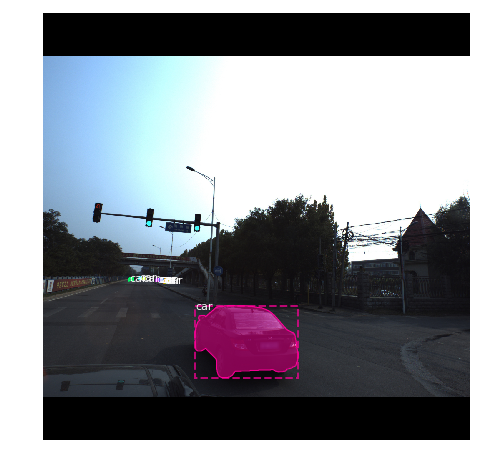

In [29]:

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.26542  max:    1.20286  float32


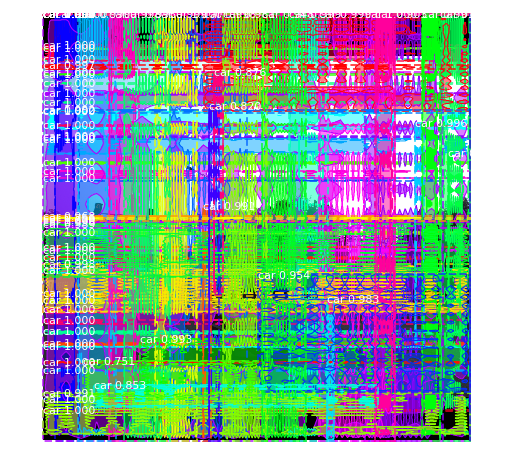

In [30]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())
